In [18]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from transformers import AutoformerModel

# Load Barcelona COVID case data
df = pd.read_csv('data/Spain/provincias_covid19_datos_sanidad_nueva_serie.csv')
df['Fecha'] = pd.to_datetime(df['Fecha'])
barcelona_df = df[df['provincia'] == 'Barcelona'].sort_values('Fecha')
cases = barcelona_df['Casos'].fillna(0).values.astype(np.float32)

# Create lagged dataset (AR(7))
def create_lagged_dataset(series, lags=7):
    X, y = [], []
    for i in range(lags, len(series)):
        X.append(series[i - lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

X, y = create_lagged_dataset(cases, lags=32)

# Normalize for training
scaler = StandardScaler()
X = scaler.fit_transform(X)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Train/test split
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Convert to tensors
X_train_tensor = torch.tensor(X_train).unsqueeze(-1)  # (B, S, C)
y_train_tensor = torch.tensor(y_train).unsqueeze(-1)  # (B, 1)
X_test_tensor = torch.tensor(X_test).unsqueeze(-1)
y_test_tensor = torch.tensor(y_test).unsqueeze(-1)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)


In [19]:
import torch.nn as nn
import torch.nn.functional as F

class SeriesStationarization:
    def normalize(self, x):
        mu = x.mean(dim=1, keepdim=True)
        std = x.std(dim=1, keepdim=True) + 1e-6
        return (x - mu) / std, mu, std

    def denormalize(self, y, mu, std):
        return y * std + mu

class DeStationaryAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.scale = d_model ** -0.5
        self.tau_mlp = nn.Linear(1, 1)
        self.delta_mlp = nn.Linear(1, d_model)

    def forward(self, Q, K, V, mu, std):
        tau = torch.sigmoid(self.tau_mlp(std.mean(dim=2))) * 2  # in [0, 2]
        delta = self.delta_mlp(mu.mean(dim=2))          # (B, D)

        Q = Q - Q.mean(dim=1, keepdim=True)
        K = K - K.mean(dim=1, keepdim=True)

        scores = tau.unsqueeze(-1) * torch.matmul(Q, K.transpose(-2, -1))  # (B, S, S)
        # scores = scores + delta.unsqueeze(1)
        attn_weights = F.softmax(scores * self.scale, dim=-1)
        return torch.matmul(attn_weights, V)

class NonStationaryBlock(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.attn = DeStationaryAttention(d_model)
        self.ff = nn.Sequential(nn.Linear(d_model, d_model * 2), nn.ReLU(), nn.Linear(d_model * 2, d_model))
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mu, std):
        h = self.attn(x, x, x, mu, std)
        x = self.norm1(x + h)
        x = self.norm2(x + self.ff(x))
        return x

class NonStationaryTransformer(nn.Module):
    def __init__(self, input_dim=1, d_model=32, num_layers=2):
        super().__init__()
        self.station = SeriesStationarization()
        self.embed = nn.Linear(input_dim, d_model)
        self.blocks = nn.ModuleList([NonStationaryBlock(d_model) for _ in range(num_layers)])
        self.proj = nn.Linear(d_model, 1)

    def forward(self, x):
        x_norm, mu, std = self.station.normalize(x)
        x_embed = self.embed(x_norm)
        for block in self.blocks:
            x_embed = block(x_embed, mu, std)
        out = self.proj(x_embed[:, -1])  # use last token
        return self.station.denormalize(out, mu[:, -1], std[:, -1])


In [20]:
import torch.nn as nn

class ProbSparseSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        self.scale = (d_model // n_heads) ** -0.5

    def forward(self, x):
        B, L, D = x.size()
        H = self.n_heads

        Q = self.q_proj(x).view(B, L, H, -1).transpose(1, 2)  # B,H,L,D/H
        K = self.k_proj(x).view(B, L, H, -1).transpose(1, 2)
        V = self.v_proj(x).view(B, L, H, -1).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale  # B,H,L,L
        A = torch.softmax(scores, dim=-1)
        out = torch.matmul(A, V)
        out = out.transpose(1, 2).contiguous().view(B, L, D)
        return self.out_proj(out)

class InformerBlock(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.attn = ProbSparseSelfAttention(d_model, n_heads)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.norm1(x + self.attn(x))
        x = self.norm2(x + self.ff(x))
        return x

class SimpleInformer(nn.Module):
    def __init__(self, input_dim=1, d_model=32, n_heads=4, num_layers=2):
        super().__init__()
        self.embed = nn.Linear(input_dim, d_model)
        self.blocks = nn.ModuleList([InformerBlock(d_model, n_heads) for _ in range(num_layers)])
        self.proj = nn.Linear(d_model, 1)

    def forward(self, x):
        x_embed = self.embed(x)
        for block in self.blocks:
            x_embed = block(x_embed)
        return self.proj(x_embed[:, -1])  # use last token


In [24]:
model = NonStationaryTransformer()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(100):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred.squeeze(), yb.squeeze())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Train Loss = {total_loss / len(train_loader):.4f}")


Epoch 1: Train Loss = 0.0352
Epoch 2: Train Loss = 0.0286
Epoch 3: Train Loss = 0.0263
Epoch 4: Train Loss = 0.0258
Epoch 5: Train Loss = 0.0249
Epoch 6: Train Loss = 0.0247
Epoch 7: Train Loss = 0.0249
Epoch 8: Train Loss = 0.0254
Epoch 9: Train Loss = 0.0248
Epoch 10: Train Loss = 0.0243
Epoch 11: Train Loss = 0.0242
Epoch 12: Train Loss = 0.0241
Epoch 13: Train Loss = 0.0237
Epoch 14: Train Loss = 0.0248
Epoch 15: Train Loss = 0.0250
Epoch 16: Train Loss = 0.0248
Epoch 17: Train Loss = 0.0242
Epoch 18: Train Loss = 0.0241
Epoch 19: Train Loss = 0.0241
Epoch 20: Train Loss = 0.0239
Epoch 21: Train Loss = 0.0238
Epoch 22: Train Loss = 0.0237
Epoch 23: Train Loss = 0.0234
Epoch 24: Train Loss = 0.0241
Epoch 25: Train Loss = 0.0240
Epoch 26: Train Loss = 0.0234
Epoch 27: Train Loss = 0.0240
Epoch 28: Train Loss = 0.0245
Epoch 29: Train Loss = 0.0237
Epoch 30: Train Loss = 0.0240
Epoch 31: Train Loss = 0.0232
Epoch 32: Train Loss = 0.0236
Epoch 33: Train Loss = 0.0241
Epoch 34: Train Los

Vanilla Transformer RMSE: 3531.29
Vanilla Transformer SMAPE: 47.77%
Vanilla Transformer MDA: 46.00%


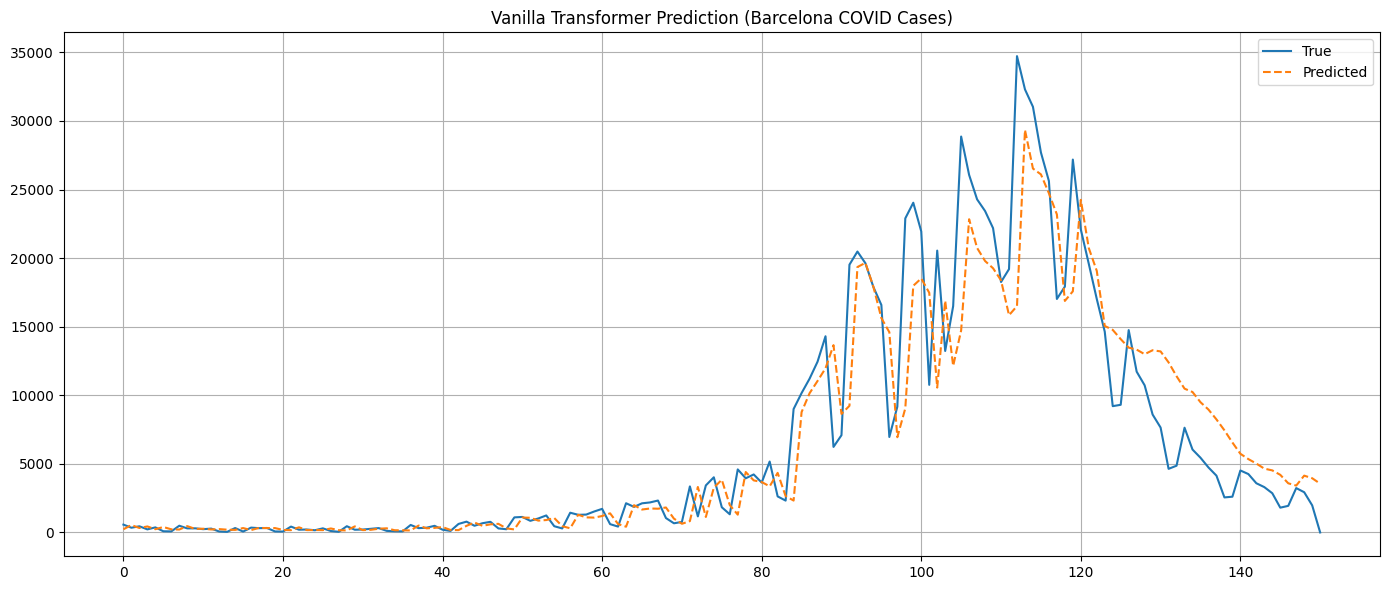

In [25]:
model.eval()
with torch.no_grad():
    y_pred_norm = model(X_test_tensor).squeeze().detach().cpu().numpy()
    y_pred = scaler_y.inverse_transform(y_pred_norm.reshape(-1, 1)).flatten()
    y_true = scaler_y.inverse_transform(y_test_tensor.squeeze().detach().cpu().numpy().reshape(-1, 1)).flatten()

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / np.maximum(denominator, 1e-10)  # avoid div by 0
    return np.mean(diff) * 100

def mean_directional_accuracy(y_true, y_pred):
    return np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred)))

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mda = mean_directional_accuracy(y_true, y_pred)
smape_score = smape(y_true, y_pred)

print(f"Vanilla Transformer RMSE: {rmse:.2f}")
print(f"Vanilla Transformer SMAPE: {smape_score:.2f}%")
print(f"Vanilla Transformer MDA: {mda:.2%}")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label="True")
plt.plot(y_pred, label="Predicted", linestyle="--")
plt.title("Vanilla Transformer Prediction (Barcelona COVID Cases)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


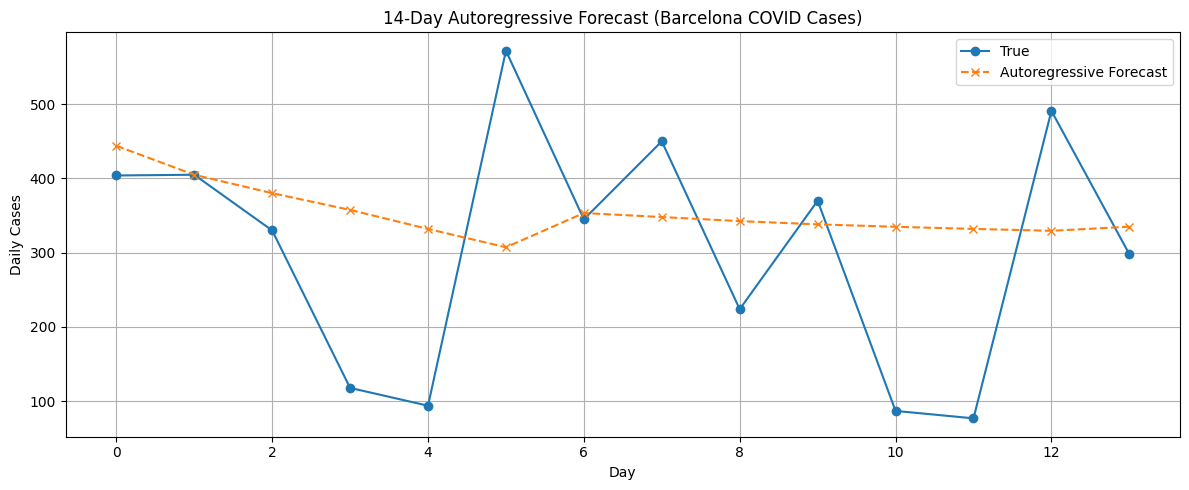

AR Forecast RMSE: 162.08
AR Forecast SMAPE: 47.74%
AR Forecast MDA: 46.15%


In [239]:
# Start from the first test sample (already standardized)
context = X_test[6].tolist()  # shape: (7,)

# Autoregressive loop: predict 14 steps ahead
predictions = []

model.eval()
with torch.no_grad():
    for _ in range(14):
        input_seq = torch.tensor(context[-7:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)  # shape: (1, 7, 1)
        pred_norm = model(input_seq).item()  # single value prediction (normalized)
        pred = scaler_y.inverse_transform([[pred_norm]])[0][0]
        predictions.append(pred)
        
        # Append normalized prediction back into context for next round
        context.append(pred_norm)

# Get the true values for comparison (first 14 points in test set)
y_true_14 = scaler_y.inverse_transform(y_test[:14].reshape(-1, 1)).flatten()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(range(14), y_true_14, label="True", marker='o')
plt.plot(range(14), predictions, label="Autoregressive Forecast", marker='x', linestyle='--')
plt.title("14-Day Autoregressive Forecast (Barcelona COVID Cases)")
plt.xlabel("Day")
plt.ylabel("Daily Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Metrics
rmse_14 = np.sqrt(mean_squared_error(y_true_14, predictions))
smape_14 = smape(y_true_14, predictions)
mda_14 = mean_directional_accuracy(y_true_14, predictions)

print(f"AR Forecast RMSE: {rmse_14:.2f}")
print(f"AR Forecast SMAPE: {smape_14:.2f}%")
print(f"AR Forecast MDA: {mda_14:.2%}")


Epoch 1: Train Loss = 0.1614
Epoch 2: Train Loss = 0.0382
Epoch 3: Train Loss = 0.0271
Epoch 4: Train Loss = 0.0232
Epoch 5: Train Loss = 0.0188
Epoch 6: Train Loss = 0.0183
Epoch 7: Train Loss = 0.0155
Epoch 8: Train Loss = 0.0166
Epoch 9: Train Loss = 0.0139
Epoch 10: Train Loss = 0.0142
Epoch 11: Train Loss = 0.0121
Epoch 12: Train Loss = 0.0117
Epoch 13: Train Loss = 0.0117
Epoch 14: Train Loss = 0.0131
Epoch 15: Train Loss = 0.0103
Epoch 16: Train Loss = 0.0130
Epoch 17: Train Loss = 0.0110
Epoch 18: Train Loss = 0.0132
Epoch 19: Train Loss = 0.0126
Epoch 20: Train Loss = 0.0098
Epoch 21: Train Loss = 0.0114
Epoch 22: Train Loss = 0.0114
Epoch 23: Train Loss = 0.0095
Epoch 24: Train Loss = 0.0131
Epoch 25: Train Loss = 0.0128
Epoch 26: Train Loss = 0.0109
Epoch 27: Train Loss = 0.0091
Epoch 28: Train Loss = 0.0112
Epoch 29: Train Loss = 0.0122
Epoch 30: Train Loss = 0.0126
Epoch 31: Train Loss = 0.0117
Epoch 32: Train Loss = 0.0091
Epoch 33: Train Loss = 0.0090
Epoch 34: Train Los

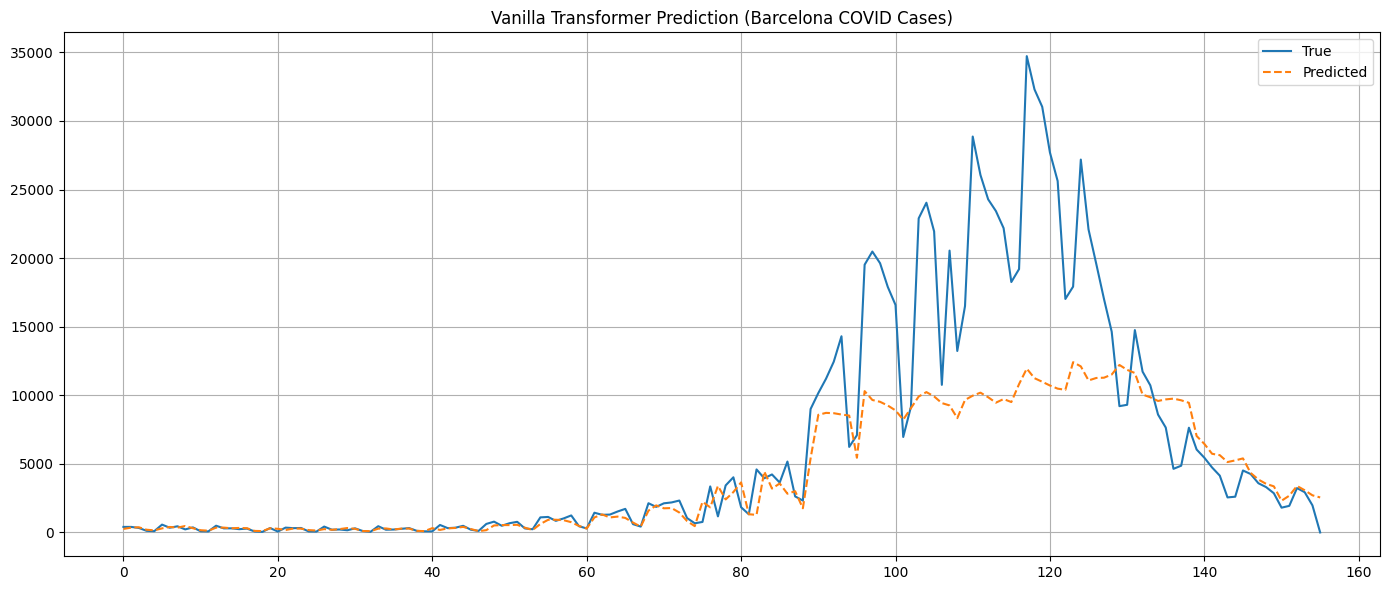

In [171]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Load and preprocess data
df = pd.read_csv('data/Spain/provincias_covid19_datos_sanidad_nueva_serie.csv')
df['Fecha'] = pd.to_datetime(df['Fecha'])
barcelona_df = df[df['provincia'] == 'Barcelona'].sort_values('Fecha')
cases = barcelona_df['Casos'].fillna(0).values.astype(np.float32)


# Create lagged dataset
def create_lagged_dataset(series, lags=7):
    X, y = [], []
    for i in range(lags, len(series)):
        X.append(series[i - lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)


X, y = create_lagged_dataset(cases, lags=7)

scaler = StandardScaler()
X = scaler.fit_transform(X)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

X_train_tensor = torch.tensor(X_train).unsqueeze(-1)
y_train_tensor = torch.tensor(y_train).unsqueeze(-1)
X_test_tensor = torch.tensor(X_test).unsqueeze(-1)
y_test_tensor = torch.tensor(y_test).unsqueeze(-1)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        self.pe = pe.unsqueeze(0)  # (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)


class VanillaTransformer(nn.Module):
    def __init__(self, input_dim=1, d_model=128, num_layers=1, nhead=8):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=128, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x)  # (B, S, d_model)
        x = self.pos_encoder(x)  # (B, S, d_model)
        x = self.transformer(x)  # (B, S, d_model)
        out = self.output_proj(x[:, -1])  # Use last token only
        return out


model = VanillaTransformer()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(50):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred.squeeze(), yb.squeeze())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}: Train Loss = {total_loss / len(train_loader):.4f}")

model.eval()
with torch.no_grad():
    y_pred_norm = model(X_test_tensor).squeeze().numpy()
    y_pred = scaler_y.inverse_transform(y_pred_norm.reshape(-1, 1)).flatten()
    y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mda = mean_directional_accuracy(y_true, y_pred)
smape_score = smape(y_true, y_pred)

print(f"Vanilla Transformer RMSE: {rmse:.2f}")
print(f"Vanilla Transformer SMAPE: {smape_score:.2f}%")
print(f"Vanilla Transformer MDA: {mda:.2%}")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label="True")
plt.plot(y_pred, label="Predicted", linestyle="--")
plt.title("Vanilla Transformer Prediction (Barcelona COVID Cases)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
